# Data preparation
* Replaced Object data types with boolean values as they were like boolean types.
* Removed columns having codes i.e. 'propertyzoningdesc','propertycountylandusecode'and transaction date.
* Replaced null values with median.

NOTE: You don't need to fill NA values in sample_submission.csv

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import gc

properties = pd.read_csv('properties_2016.csv')
train = pd.read_csv('train_2016_v2.csv')
print(train.shape)
print(properties.shape)

train = pd.merge(train, properties, on='parcelid', how='left')

# Convert object types to boolean as all object types are boolean types of values
#print(train.dtypes)
#print('propertycountylandusecode', train['propertycountylandusecode'].value_counts()) # 75 codes
#print('propertyzoningdesc', train['propertyzoningdesc'].value_counts()) # 1907 codes
#print('hashottuborspa', train['hashottuborspa'].value_counts()) # True False
#print('fireplaceflag', train['fireplaceflag'].value_counts()) # True False
#print('taxdelinquencyflag', train['taxdelinquencyflag'].value_counts()) #Y N 
for c in train.dtypes[train.dtypes == object].index.values:
    train[c] = (train[c] == True)
    
# Fill missing values with median or mean?????
median_values = train.mean(axis=0)
train.fillna(median_values, inplace=True)

# Convert datatype to float32 to accept in Kaggle
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)
        
# Remove codes columns
x = train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 
                         'propertycountylandusecode',  'fireplacecnt', 'fireplaceflag'], axis=1)
y = train['logerror'].values
print(x.shape, y.shape)
train_columns = x.columns
x = x.as_matrix()

# Sample submission data preperation
sample = pd.read_csv('sample_submission.csv')
#sample['parcelid'] = sample['ParcelId']
df_test = pd.merge(sample, properties, left_on='ParcelId', right_on='parcelid')

xtest = df_test[train_columns]
for c in xtest.dtypes[xtest.dtypes == object].index.values:
    xtest[c] = (xtest[c] == True)

xtest = xtest.fillna(xtest.mean(axis=0), inplace=True)

# Convert datatype to float32 to accept in Kaggle
for c, dtype in zip(xtest.columns, xtest.dtypes):
    if dtype == np.float64:
        xtest[c] = xtest[c].astype(np.float32)
xtest = xtest.as_matrix()

C:\Users\dexter\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(90275, 3)
(2985217, 58)
(90275, 53) (90275,)


C:\Users\dexter\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dexter\Anaconda3\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\dexter\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

# Comparision of different regression methods.
* Linear Regression
* Lasso 
* Ridge regression
* ElasticNet
* Randomized Lasso
* XGB Regressor - (It is Tree based)
* Random Forest Regressor - (Type of Decision Tree)
* Stochaistic Gradient Descent

We see that linear models such as linear regression, lasso, ridge don't perform well. This makes sense because there is no linear dependency of the logerror from any feature.
We see that XGB Regressor performs the best. It has least RMSE values and 10-fold cross-validation.

**ElasticNet** is a linear regression model that combines L1 with L2 regularization. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. ElasticNet is useful when there are multiple features correlated with one another

**Something is going wrong with R2 values... Check later**

In [2]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RandomizedLasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.7,random_state=100)
a = 0.3
for name,met in [
        ('linear regression', LinearRegression()),
        ('lasso', Lasso(fit_intercept=True, alpha=a)),
        ('ridge', Ridge(fit_intercept=True, alpha=a)),
        ('elastic-net', ElasticNet(fit_intercept=True, alpha=a)),
        ('KNN', KNeighborsRegressor(n_neighbors = 100)),
        ('randomForest', RandomForestRegressor(max_depth= 8, n_estimators = 100)), #taking a lot of time.
        ('xgboost', XGBRegressor())
        ]:
    met.fit(x_train,y_train)
    # p = np.array([met.predict(xi) for xi in x])
    p = met.predict(x_test)
    e = p-y_test
    total_error = np.dot(e,e)
    rmse_train = np.sqrt(total_error/len(p))
    
    R2score = met.score(x_test,y_test)

    kf = KFold(len(x), n_folds=10)
    err = 0
    for train,test in kf:
        met.fit(x[train],y[train])
        p = met.predict(x[test])
        e = p-y[test]
        err += np.dot(e,e)

    rmse_10cv = np.sqrt(err/len(x))
    print('Method: %s' %name)
    print('RMSE on training: %.4f' %rmse_train)
    print('R2 score: %.4f' %R2score)
    print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
    print ("\n")

C:\Users\dexter\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Method: linear regression
RMSE on training: 0.1613
R2 score: 0.0003
RMSE on 10-fold CV: 0.1609




C:\Users\dexter\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Method: lasso
RMSE on training: 0.1610
R2 score: 0.0033
RMSE on 10-fold CV: 0.1608


Method: ridge
RMSE on training: 0.1613
R2 score: 0.0003
RMSE on 10-fold CV: 0.1609


Method: elastic-net
RMSE on training: 0.1610
R2 score: 0.0031
RMSE on 10-fold CV: 0.1608


Method: KNN
RMSE on training: 0.1616
R2 score: -0.0038
RMSE on 10-fold CV: 0.1614


Method: randomForest
RMSE on training: 0.1619
R2 score: -0.0080
RMSE on 10-fold CV: 0.1608


Method: xgboost
RMSE on training: 0.1617
R2 score: -0.0046
RMSE on 10-fold CV: 0.1608




# SGD (Stochaistic Gradient Descent) Regression

In [10]:
# SGD is very senstitive to varying-sized feature values. So, first we need to do feature scaling.

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

scaler = StandardScaler()
scaler.fit(x)
x_s = scaler.transform(x)

sgdreg = SGDRegressor(penalty='l2', alpha=0.15, n_iter=200)

# Compute RMSE on training data
sgdreg.fit(x_s,y)
p = sgdreg.predict(x_s)
err = p-y
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))

# Compute RMSE using 10-fold x-validation
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    scaler = StandardScaler()
    scaler.fit(x[train])  # Don't cheat - fit only on training data
    xtrain_s = scaler.transform(x[train])
    xtest_s = scaler.transform(x[test])  # apply same transformation to test data
    sgdreg.fit(xtrain_s,y[train])
    p = sgdreg.predict(xtest_s)
    e = p-y[test]
    xval_err += np.dot(e,e)
rmse_10cv = np.sqrt(xval_err/len(x))

method_name = 'Stochastic Gradient Descent Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

C:\Users\dexter\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dexter\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Method: Stochastic Gradient Descent Regression
RMSE on training: 0.1613
RMSE on 10-fold CV: 34741009230.4219


# Feature Selection via Randomized Lasso

In [8]:
from sklearn.linear_model import RandomizedLasso
from sklearn.preprocessing import MinMaxScaler

# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(x, y)
print(np.abs(rlasso.scores_))
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), train_columns)
print('finished')

C:\Users\dexter\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
finished


# Predict SampleSubmission with LinearRegression
Linear regression gives a negative R2 score. It means the model fits your data very badly, even a horizontal line does better at the prediction than the model.
https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean

In other words, the model is working opposite to the given data.
<img src="R2score.png">

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.7,random_state=100)

from sklearn.linear_model import LinearRegression
lm= LinearRegression()
lm.fit(x_train,y_train)
y_pred=lm.predict(x_test)

print('LinearRegression R2score(percentage of variance from the predictions.):',lm.score(x_test,y_test))
print('The rmse of linear regression prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

del x_train; gc.collect()
del x_test; gc.collect()
del y_train; gc.collect()
del y_test; gc.collect()
del y_pred; gc.collect()

# Prediction with sampleSubmission data
prd = lm.predict(xtest)

#sub = pd.read_csv('sample_submission.csv', nrows=20000)
sub = pd.read_csv('sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = prd

print('Writing csv ...')
sub.to_csv('linear_model.csv', index=False, float_format='%.4f')

LinearRegression R2score(percentage of variance from the predictions.): 0.000300770557502
The rmse of linear regression prediction is: 0.161259540878
Writing csv ...


# Predict SampleSubmission with RandomForestRegressor

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.7,random_state=100)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth= 8, n_estimators = 100)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print('RandomForest score:',rf.score(x_test,y_test))
print('The rmse of randomForest prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

del x_train; gc.collect()
del x_test; gc.collect()
del y_train; gc.collect()
del y_test; gc.collect()

# Prediction with sampleSubmission data
prd = rf.predict(xtest)

sub = pd.read_csv('sample_submission.csv')
test_columns = ['201610','201611','201612','201710','201711','201712']
for c in test_columns:
    sub[c] = prd

print('Writing csv ...')
sub.to_csv('randomForest_model.csv', index=False, float_format='%.4f')

# Feature importance with XGB (Extreme Gradient Boosting)

XGB R2score: -0.00461587284842
The rmse of XGBoost prediction is: 0.161655595214
XBG best score :  0.0279044850893


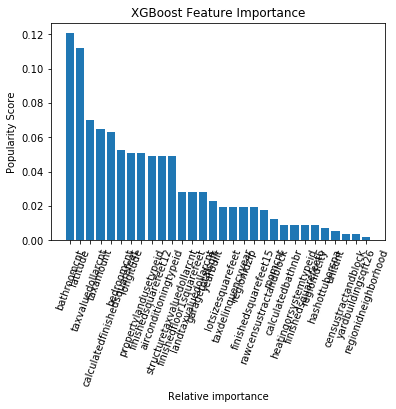

In [12]:
import operator

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.7,random_state=100)

from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)

print('XGB R2score:',xgb.score(x_test,y_test))
print('The rmse of XGBoost prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('XBG best score : ', xgb.score(x,y))

# Now we will see feature importances
impVals = xgb.booster().get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(train_columns)}
total = sum(impVals.values())
mapped = {mapper[k]: v/total for k, v in impVals.items()}
mapped = sorted(mapped.items(), key=operator.itemgetter(1), reverse=True)

prop = [val[0] for val in mapped] #list(zip(*mapped))[0]
score = [val[1] for val in mapped] #list(zip(*mapped))[1]
x_pos = np.arange(len(prop)) 
   
plt.bar(x_pos, score,align='center')
plt.xticks(x_pos, prop) 
plt.xticks(rotation=70)
plt.title('XGBoost Feature Importance')
plt.xlabel('Relative importance')
plt.ylabel('Popularity Score')
plt.show()

# Feature Importance with LightGBM

Getting a quick tree-based feature importance classification. I'm using a LightGBM model shared by another member of the Kaggle community.
LightGBM is a gradient boosting framework based on decision tree algorithms that can be used for quick ranking and classification tasks. It was recently open-sourced by Microsoft as part of the DMTK project.

Start training...


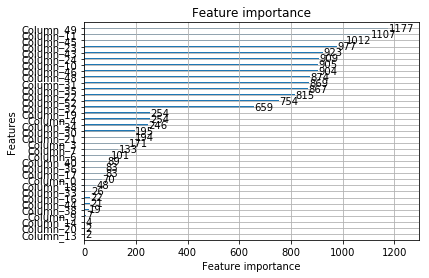

Start predicting...
The rmse of LightGBM prediction is: 0.16079876701


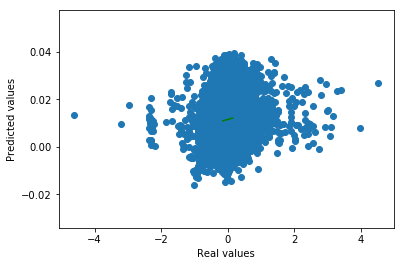

(2985217, 53)
          0
0  0.003878
1  0.002368
2  0.012247
3  0.007230
4  0.000568
Writing csv ...


In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.7,random_state=100)

import lightgbm as lgb

# specify your configurations as a dict
params = {}
params['max_bin'] = 20
params['learning_rate'] = 0.0025 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.345    
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

print('Start training...')
#gbm = lgb.train(params,
#                lgb_train,
#                num_boost_round=20,
#                valid_sets=lgb_eval,
#                early_stopping_rounds=5)
gbm = lgb.train(params, lgb_train, 430)
lgb.plot_importance(gbm)
plt.figure(figsize=(7,4))
plt.show()

print('Start predicting...')
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

print('The rmse of LightGBM prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

plt.scatter(y_test, y_pred)
plt.xlabel('Real values')
plt.ylabel('Predicted values')

# Add a trend line
regression = np.polyfit(y_test, y_pred, 1)
x_vals = np.array([-0.15, 0.15])
y_vals = regression[0]*x_vals + regression[1]
plt.plot(x_vals, y_vals, color='green')

plt.show()

del x_train; gc.collect()
del x_test; gc.collect()
del y_train; gc.collect()
del y_test; gc.collect()

# Prediction with sampleSubmission data
print(pd.DataFrame(xtest).shape)
lgb_train = lgb.Dataset(x, y)
gbm = lgb.train(params, lgb_train, 430)
prd = gbm.predict(xtest)
print(pd.DataFrame(prd).head())

sub = pd.read_csv('sample_submission.csv')
test_columns = ['201610','201611','201612','201710','201711','201712']
for c in test_columns:
    sub[c] = prd

print('Writing csv ...')
sub.to_csv('lightGBM_model.csv', index=False, float_format='%.4f')

# Cutting out outliers
Apparently there are houses in the dataset for which Zillow’s algorithm made large errors. Normally one might think that the outliers are the most interesting to look at, because that’s where there is a lot of room for improvement. However, for our current purposes this may not be the case, because

1) the error may be large simply because the price of the house is high;

2) for high-value houses, not much data is available, so we may not be able to learn much;

3) the market for high-value houses is small, so that prices are dependent on the tastes and funds of available buyers, leading to unpredictable variance.

Of course the above may or may not be the real underlying reason for the outliers, but it suggests that it may be worth trying to remove the outliers from the training set, because they may not contain much generalizable information.

[ 0.0276     -0.1684     -0.004      ..., -0.26789999  0.0602      0.42070001]


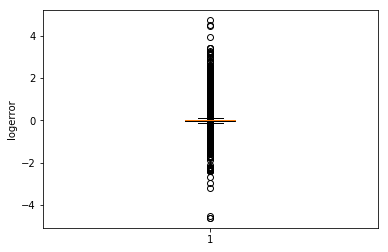

In [14]:
print(y)
plt.boxplot(y)
plt.ylabel('logerror')
plt.show()

In [15]:
# Quick function to find outliers. A data point in a series is considered
# an outlier if it is more than the inter-quartile range (IQR), multiplied
# by some factor, away from the first or third quartile.
def getIQROutlierBool(series, factor):
    q1 = series.quantile(0.25) # First quartile
    q3 = series.quantile(0.75) # Third quartile
    
    # Generate a boolean series indicating whether or not the data point is
    # within the specified range
    iqr = (series > q1-factor*(q3-q1)) & (series < q3+factor*(q3-q1))
    return iqr

yPrime = pd.Series(y)

# Apply the filter to our logerror values
outlier_filter = getIQROutlierBool(yPrime, 1.5)

# Cut out the outliers from the training set
xClean = x[outlier_filter]
yClean = y[outlier_filter]
print('Before removing outliers', x.shape)
print(y.shape)
print('After  removing outliers', xClean.shape)
print(yClean.shape)

Before removing outliers (90275, 53)
(90275,)
After  removing outliers (79697, 53)
(79697,)


# XGB boost after removing outliers

In [16]:
import operator

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(xClean,yClean,test_size=0.7,random_state=100)

from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)

print('XGB R2score:',xgb.score(x_test,y_test))
print('The rmse of XGBoost prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

XGB R2score: 0.0214516429197
The rmse of XGBoost prediction is: 0.0462556618893
